# Pytorch starter - FasterRCNN Inference

- You can find the [train notebook here](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train)
- The weights are [available here](https://www.kaggle.com/dataset/7d5f1ed9454c848ecb909c109c6fa8e573ea4de299e249c79edc6f47660bf4c5)

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

DIR_WEIGHTS = '/kaggle/input/global-wheat-detection-public'

WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn_best.pth'

In [2]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.shape

(10, 2)

In [3]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [4]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])


In [5]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [8]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [9]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)


In [10]:
results[0:2]

[{'image_id': 'aac893a91',
  'PredictionString': '0.9966 553 535 135 188 0.9948 616 920 77 103 0.9947 68 2 102 162 0.9933 592 780 92 119 0.9920 326 666 124 153 0.9891 25 457 109 158 0.9877 816 703 105 204 0.9872 177 566 113 188 0.9862 741 774 80 114 0.9854 692 392 124 180 0.9828 236 842 159 111 0.9747 359 533 94 81 0.9738 458 862 82 97 0.9669 240 85 136 148 0.9100 90 621 117 73 0.9060 67 859 111 68 0.8893 483 8 214 251 0.8820 306 0 71 67 0.7265 821 632 86 112 0.7254 819 918 127 105 0.6762 360 268 95 143'},
 {'image_id': '51f1be19e',
  'PredictionString': '0.9974 607 93 162 177 0.9950 843 268 133 201 0.9945 505 472 203 110 0.9922 271 470 144 125 0.9872 769 884 148 104 0.9839 808 764 103 92 0.9826 58 687 140 221 0.9786 818 95 107 86 0.9741 561 601 121 120 0.9717 29 1 83 70 0.9696 341 141 108 179 0.9562 697 921 82 86 0.9353 0 380 55 107 0.9314 194 939 102 84 0.9277 662 586 105 90 0.9215 250 128 110 107 0.9015 652 792 99 80 0.7868 876 652 136 105 0.6531 916 567 89 108'}]

In [11]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9966 553 535 135 188 0.9948 616 920 77 103 0...
1,51f1be19e,0.9974 607 93 162 177 0.9950 843 268 133 201 0...
2,f5a1f0358,0.9959 540 276 110 114 0.9953 939 435 84 185 0...
3,796707dd7,0.9930 940 75 84 100 0.9922 895 333 113 92 0.9...
4,51b3e36ab,0.9988 836 456 187 146 0.9982 544 33 246 131 0...


In [12]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

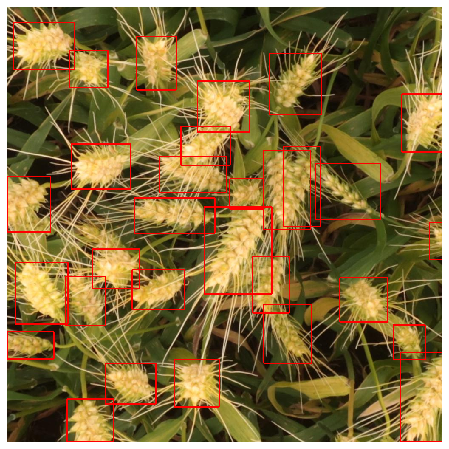

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [14]:
test_df.to_csv('submission.csv', index=False)